# A/B Test (Complex)

**Scenario:**  
An e-commerce site tests a new recommender (**Treatment B**) vs the current one (**Control A**).

**Primary KPI:**  
- Conversion Rate (CR) — purchases / visitors

**Secondary KPIs:**  
- Click-Through Rate (CTR)  
- Average Order Value (AOV)  
- Revenue per Visitor (RPV)

**Design:**  
- 50/50 random assignment at user level  
- 100k sessions over 14 days

**Hypotheses (one-sided, expecting improvement):**  
- **H0:** $CR_B \leq CR_A$  
- **H1:** $CR_B > CR_A$

> We’ll also examine CTR and RPV with multiple-testing control (FDR).

In [2]:
# Imports & Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.weightstats import DescrStatsW

np.random.seed(42)
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

In [3]:
# Simulate a realistic dataset (100k sessions, 14 days)

N = 100_000

# Users and sessions
user_ids = np.random.choice(np.arange(1, 60_001), size=N, replace=True)  # some users have multiple sessions

# Randomized assignment (user-level assignment for consistency)
# Assign each user once, then map to sessions
unique_users = np.unique(user_ids)
user_group_map = pd.Series(
    np.random.choice(['A','B'], size=unique_users.shape[0], p=[0.5, 0.5]),
    index=unique_users
)
groups = pd.Series(user_ids).map(user_group_map).values

# Context features
devices = np.random.choice(['desktop','mobile'], size=N, p=[0.45, 0.55])
countries = np.random.choice(['US','CA','UK','DE','IN','BR','Other'], size=N,
                             p=[0.35,0.08,0.10,0.08,0.20,0.10,0.09])
sources = np.random.choice(['seo','sem','email','direct','social','display'], size=N,
                           p=[0.30,0.20,0.15,0.15,0.12,0.08])
days = np.random.choice(pd.date_range('2025-07-15','2025-07-28', freq='D'), size=N)

# Pre-period covariate (for CUPED): historical clicks per user
user_hist_clicks = pd.Series(
    np.random.gamma(shape=1.2, scale=0.8, size=unique_users.shape[0]),  # over-dispersed, skewed
    index=unique_users
)
hist_clicks = pd.Series(user_ids).map(user_hist_clicks).values

# Baseline propensities (device/country/source effects)
base_ctr = 0.18 + (devices == 'mobile')*0.02 + (sources == 'email')*0.03 + (countries == 'US')*0.01
base_ctr = np.clip(base_ctr, 0.05, 0.6)

# Treatment effect on CTR: stronger on mobile, modest on desktop
ctr_uplift = ((groups == 'B') * (0.010 + (devices == 'mobile')*0.008)).astype(float)
p_click = np.clip(base_ctr + ctr_uplift, 0.01, 0.9)

clicked = np.random.binomial(1, p_click, size=N)

# Conversion given click (CR conditional on click)
base_cr_click = 0.25 + (devices == 'desktop')*0.03 + (sources == 'sem')*0.02 + (countries == 'US')*0.02
base_cr_click = np.clip(base_cr_click, 0.05, 0.7)

# Treatment effect on post-click conversion: modest, uniform
cr_uplift = ((groups == 'B') * 0.015).astype(float)
p_conv_given_click = np.clip(base_cr_click + cr_uplift, 0.01, 0.95)

converted = np.where(clicked==1,
                     np.random.binomial(1, p_conv_given_click),
                     0)

# Order value (AOV) if converted: lognormal w/ slight uplift for B
mu_AOV = 3.2 + (groups == 'B')*0.03 + (countries == 'US')*0.05  # log-space mean tweaks
sigma_AOV = 0.55
order_value = np.where(converted==1, np.random.lognormal(mean=mu_AOV, sigma=sigma_AOV), 0.0)

# Session-level revenue
revenue = order_value

df = pd.DataFrame({
    'user_id': user_ids,
    'group': groups,
    'device': devices,
    'country': countries,
    'source': sources,
    'date': days,
    'hist_clicks': hist_clicks,
    'clicked': clicked,
    'converted': converted,
    'revenue': revenue
})

# Derived metrics
df['rpv'] = df['revenue']                # revenue per visitor (session)
df['ctr'] = df['clicked']                # click-through (binary per session)
df['cr']  = df['converted']              # conversion (binary per session)

df.head()

,user_id,group,device,country,source,date,hist_clicks,clicked,converted,revenue,rpv,ctr,cr
0,56423,A,mobile,IN,email,2025-07-27,1.074953,1,0,0.000000,0.000000,1,0
1,15796,A,mobile,US,email,2025-07-27,7.663960,0,0,0.000000,0.000000,0,0
2,861,B,desktop,UK,social,2025-07-23,1.336186,0,0,0.000000,0.000000,0,0
3,38159,A,desktop,US,email,2025-07-16,1.830122,0,0,0.000000,0.000000,0,0
4,54344,A,mobile,UK,seo,2025-07-20,1.043835,1,1,22.807347,22.807347,1,1


In [4]:
# Sanity check: SRM test (Sample Ratio Mismatch)
# H0: observed allocation = 50/50. Use chi-square goodness-of-fit.

alloc = df['group'].value_counts().sort_index()
expected = np.array([0.5*len(df), 0.5*len(df)])
chi2 = ((alloc.values - expected)**2 / expected).sum()
p_srm = 1 - stats.chi2.cdf(chi2, df=1)

print("Allocation:")
print(alloc)
print(f"\nSRM chi2={chi2:.4f}, p={p_srm:.4f} (p>0.01 means no SRM usually)")

Allocation:
group
A    49850
B    50150
Name: count, dtype: int64

SRM chi2=0.9000, p=0.3428 (p>0.01 means no SRM usually)


In [5]:
# Overall KPIs by group

def summarize_binary(metric):
    g = df.groupby('group')[metric].agg(['mean','sum','count'])
    g['rate_pct'] = g['mean']*100
    return g

ctr_summary = summarize_binary('ctr')
cr_summary  = summarize_binary('cr')
rpv_summary = df.groupby('group')['rpv'].agg(['mean','count','sum']).rename(columns={'mean':'rpv_mean'})

print("CTR Summary:\n", ctr_summary, "\n")
print("CR Summary:\n", cr_summary, "\n")
print("RPV Summary:\n", rpv_summary, "\n")

CTR Summary:
           mean    sum  count  rate_pct
group                                 
A     0.200622  10001  49850 20.062187
B     0.211186  10591  50150 21.118644 

CR Summary:
           mean   sum  count  rate_pct
group                                
A     0.054524  2718  49850  5.452357
B     0.062114  3115  50150  6.211366 

RPV Summary:
        rpv_mean  count           sum
group                               
A      1.574255  49850 78,476.634379
B      1.911134  50150 95,843.349173 



In [6]:
# Classical tests: two-proportion z-tests (CTR & CR), and t-test / bootstrap for RPV

def two_prop_test(metric):
    g = df.groupby('group')[metric].agg(['sum','count'])
    count = g['sum'].reindex(['A','B']).values
    nobs  = g['count'].reindex(['A','B']).values
    stat, p = proportions_ztest(count, nobs, alternative='smaller')  # A vs B? We'll compute uplift and do one-sided B>A
    # We want B > A, so test A >= B (smaller for A)
    # For clarity, compute uplift and one-sided p properly:
    # Better: compute z and use one-sided in direction of B>A
    stat_better, p_two = proportions_ztest(count, nobs)  # two-sided
    # Convert to one-sided for B>A:
    # if diff = pB - pA; if diff>0, p_one = p_two/2 else 1 - p_two/2
    pA = count[0]/nobs[0]; pB = count[1]/nobs[1]
    diff = pB - pA
    p_one = p_two/2 if diff>0 else 1 - p_two/2
    
    # 95% CI (Wald) for each group
    ciA = proportion_confint(count[0], nobs[0], method='normal')
    ciB = proportion_confint(count[1], nobs[1], method='normal')
    return {
        'pA': pA, 'pB': pB, 'uplift_abs': diff,
        'p_one_sided_B_gt_A': p_one,
        'ciA': ciA, 'ciB': ciB
    }

ctr_test = two_prop_test('ctr')
cr_test  = two_prop_test('cr')

# RPV: distribution is skewed (lots of zeros), use bootstrap for mean difference
def bootstrap_mean_diff(xA, xB, B=10_000):
    nA, nB = len(xA), len(xB)
    diffs = np.empty(B)
    for b in range(B):
        sA = xA[np.random.randint(0, nA, nA)]
        sB = xB[np.random.randint(0, nB, nB)]
        diffs[b] = sB.mean() - sA.mean()
    ci = (np.percentile(diffs, 2.5), np.percentile(diffs, 97.5))
    p_one = 1 - (diffs > 0).mean()    # one-sided p for B>A
    return diffs.mean(), ci, p_one

xA = df.loc[df.group=='A','rpv'].values
xB = df.loc[df.group=='B','rpv'].values
rpv_diff_mean, rpv_ci, rpv_p_one = bootstrap_mean_diff(xA, xB, B=5000)

print("CTR test:", ctr_test)
print("CR test:", cr_test)
print(f"RPV diff mean={rpv_diff_mean:.4f}, 95% CI={rpv_ci}, one-sided p(B>A)={rpv_p_one:.4f}")

CTR test: {'pA': 0.20062186559679038, 'pB': 0.2111864406779661, 'uplift_abs': 0.010564575081175726, 'p_one_sided_B_gt_A': 1.8071767804632015e-05, 'ciA': (0.19710641681912394, 0.2041373143744568), 'ciB': (0.20761426489972623, 0.21475861645620598)}
CR test: {'pA': 0.054523570712136406, 'pB': 0.06211365902293121, 'uplift_abs': 0.007590088310794801, 'p_one_sided_B_gt_A': 1.5229517956922868e-07, 'ciA': (0.05253045272847003, 0.05651668869580278), 'ciB': (0.060001234090762474, 0.06422608395509993)}
RPV diff mean=0.3378, 95% CI=(0.23571589387520733, 0.43834058263823034), one-sided p(B>A)=0.0000


In [7]:
# Multiple testing control (FDR via Benjamini-Hochberg)
# We test: CTR, CR, RPV (three hypotheses, one-sided for B>A).
pvals = np.array([
    ctr_test['p_one_sided_B_gt_A'],
    cr_test['p_one_sided_B_gt_A'],
    rpv_p_one
])
metrics = np.array(['CTR','CR','RPV'])

# BH procedure
rank = pvals.argsort()
sorted_p = pvals[rank]
m = len(pvals)
bh_thresh = np.array([ (i+1)/m * 0.05 for i in range(m) ])  # alpha=0.05
is_sig_sorted = sorted_p <= bh_thresh
# Largest k where sorted_p[k] <= bh_thresh[k]
k = np.where(is_sig_sorted)[0]
kmax = k.max() if len(k)>0 else -1
reject_sorted = np.zeros(m, dtype=bool)
if kmax >= 0:
    reject_sorted[:kmax+1] = True
reject = np.empty(m, dtype=bool)
reject[rank] = reject_sorted

fdr_table = pd.DataFrame({'metric':metrics, 'p_one_sided':pvals, 'reject@FDR0.05':reject})
fdr_table

,metric,p_one_sided,reject@FDR0.05
0,CTR,0.000018,True
1,CR,0.000000,True
2,RPV,0.000000,True


In [8]:
# CUPED on CTR to reduce variance
# y = session-level click (0/1), x = pre-period covariate (hist_clicks normalized)
df['hist_clicks_norm'] = (df['hist_clicks'] - df['hist_clicks'].mean()) / df['hist_clicks'].std()
y = df['ctr'].values
x = df['hist_clicks_norm'].values

theta = np.cov(y, x, ddof=1)[0,1] / np.var(x, ddof=1)
df['ctr_cuped'] = df['ctr'] - theta * df['hist_clicks_norm']

# Test CTR with CUPED (two-sample t-test on adjusted mean; data remains ~not normal but large N helps CLT)
ctrA = df.loc[df.group=='A','ctr_cuped'].values
ctrB = df.loc[df.group=='B','ctr_cuped'].values
# Welch's t-test
t_stat, p_two = stats.ttest_ind(ctrB, ctrA, equal_var=False)
p_one = p_two/2 if (ctrB.mean() - ctrA.mean())>0 else 1 - p_two/2

cuped_result = {
    'theta': theta,
    'A_mean': ctrA.mean(),
    'B_mean': ctrB.mean(),
    'uplift_abs': ctrB.mean() - ctrA.mean(),
    'p_one_sided_B_gt_A': p_one
}
cuped_result

{'theta': 0.0007485424837723111,
 'A_mean': 0.20061927786890854,
 'B_mean': 0.21118901292592046,
 'uplift_abs': 0.01056973505701192,
 'p_one_sided_B_gt_A': 1.788517088044874e-05}

In [9]:
# Heterogeneity: by device and source (simple subgroup analysis)

def subgroup_test(df, by, metric='cr'):
    out = []
    for val, gdf in df.groupby(by):
        g = gdf.groupby('group')[metric].agg(['sum','count'])
        if 'A' in g.index and 'B' in g.index:
            count = g.loc[['A','B'],'sum'].values
            nobs = g.loc[['A','B'],'count'].values
            stat, p_twosided = proportions_ztest(count, nobs)
            pA = count[0]/nobs[0]; pB = count[1]/nobs[1]
            diff = pB - pA
            p_one = p_twosided/2 if diff>0 else 1 - p_twosided/2
            out.append([val, pA, pB, diff, p_one, nobs.sum()])
    return pd.DataFrame(out, columns=[by, 'pA','pB','uplift_abs','p_one_sided_B_gt_A','n'])

by_device = subgroup_test(df, 'device', 'cr')
by_source = subgroup_test(df, 'source', 'cr')

by_device, by_source

(    device       pA       pB  uplift_abs  p_one_sided_B_gt_A      n
 0  desktop 0.053943 0.062109    0.008166            0.000109  44827
 1   mobile 0.054998 0.062117    0.007119            0.000185  55173,
     source       pA       pB  uplift_abs  p_one_sided_B_gt_A      n
 0   direct 0.052574 0.057669    0.005095            0.086913  14852
 1  display 0.049581 0.049164   -0.000417            0.534291   8000
 2    email 0.058847 0.072125    0.013278            0.000518  14947
 3      sem 0.054274 0.068539    0.014266            0.000013  20079
 4      seo 0.054991 0.058293    0.003303            0.107454  30147
 5   social 0.054134 0.062542    0.008408            0.024798  11975)

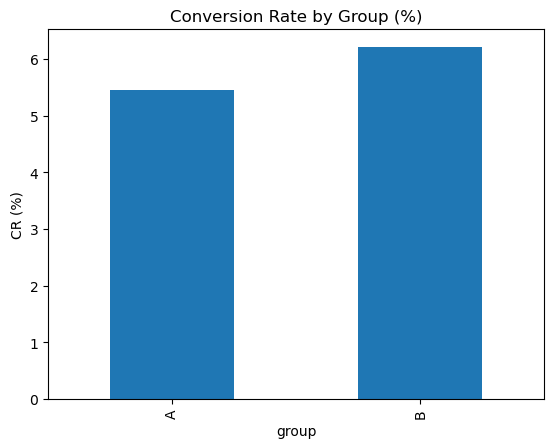

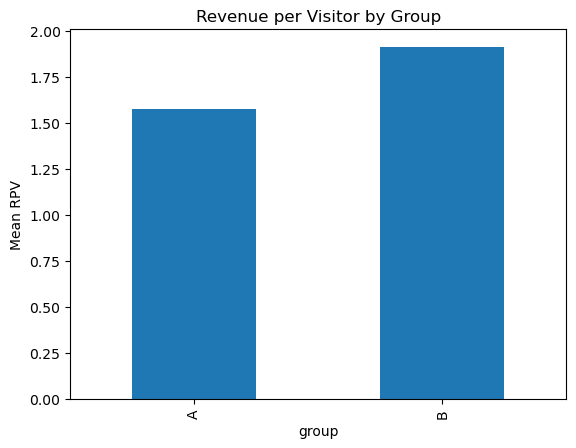

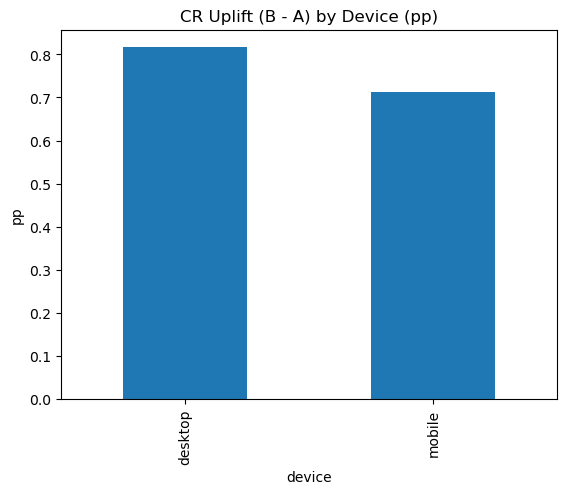

In [10]:
# Simple visualizations (matplotlib)
# Note: In Jupyter these render inline.

# Conversion rate by group
conv_rates = df.groupby('group')['cr'].mean() * 100
plt.figure()
conv_rates.plot(kind='bar')
plt.title('Conversion Rate by Group (%)')
plt.ylabel('CR (%)')
plt.show()

# Revenue per visitor by group
rpv_means = df.groupby('group')['rpv'].mean()
plt.figure()
rpv_means.plot(kind='bar')
plt.title('Revenue per Visitor by Group')
plt.ylabel('Mean RPV')
plt.show()

# Subgroup CR uplift by device
plt.figure()
uplift_by_device = by_device.set_index('device')['uplift_abs']*100
uplift_by_device.plot(kind='bar')
plt.title('CR Uplift (B - A) by Device (pp)')
plt.ylabel('pp')
plt.show()

In [11]:
# Practical interpretation

def summarize_results():
    # Overall metrics
    pA_cr, pB_cr = cr_test['pA'], cr_test['pB']
    pA_ctr, pB_ctr = ctr_test['pA'], ctr_test['pB']
    rpv_uplift = rpv_diff_mean
    print("=== Overall Results ===")
    print(f"CR: A={pA_cr:.4%}, B={pB_cr:.4%}, Abs. uplift={pB_cr - pA_cr:.2%}, p_one={cr_test['p_one_sided_B_gt_A']:.4f}")
    print(f"CTR: A={pA_ctr:.4%}, B={pB_ctr:.4%}, Abs. uplift={pB_ctr - pA_ctr:.2%}, p_one={ctr_test['p_one_sided_B_gt_A']:.4f}")
    print(f"RPV uplift (B-A): {rpv_uplift:.4f}, 95% CI={rpv_ci}, p_one={rpv_p_one:.4f}")
    print("\nMultiple Testing (FDR@0.05):")
    print(fdr_table.sort_values('p_one_sided'))
    print("\nCUPED (CTR):")
    print(cuped_result)
    print("\nHeterogeneity by device (CR):")
    print(by_device.sort_values('p_one_sided_B_gt_A'))
    print("\nHeterogeneity by source (CR):")
    print(by_source.sort_values('p_one_sided_B_gt_A'))

summarize_results()

=== Overall Results ===
CR: A=5.4524%, B=6.2114%, Abs. uplift=0.76%, p_one=0.0000
CTR: A=20.0622%, B=21.1186%, Abs. uplift=1.06%, p_one=0.0000
RPV uplift (B-A): 0.3378, 95% CI=(0.23571589387520733, 0.43834058263823034), p_one=0.0000

Multiple Testing (FDR@0.05):
  metric  p_one_sided  reject@FDR0.05
2    RPV     0.000000            True
1     CR     0.000000            True
0    CTR     0.000018            True

CUPED (CTR):
{'theta': 0.0007485424837723111, 'A_mean': 0.20061927786890854, 'B_mean': 0.21118901292592046, 'uplift_abs': 0.01056973505701192, 'p_one_sided_B_gt_A': 1.788517088044874e-05}

Heterogeneity by device (CR):
    device       pA       pB  uplift_abs  p_one_sided_B_gt_A      n
0  desktop 0.053943 0.062109    0.008166            0.000109  44827
1   mobile 0.054998 0.062117    0.007119            0.000185  55173

Heterogeneity by source (CR):
    source       pA       pB  uplift_abs  p_one_sided_B_gt_A      n
3      sem 0.054274 0.068539    0.014266            0.000013  

## Conclusions & Recommendations

- **Sanity checks:**  
  SRM p-value = 0.3428 > 0.01: randomization looks healthy.

- **Primary KPI (CR):**
    - Absolute uplift = 0.76%, one-sided p-value (B > A) = 0.0000  
    - Significant after FDR: **win**

- **Secondary KPIs (CTR / RPV):**
    - CTR absolute uplift = 1.06%, one-sided p-value = 0.000018: significant  
    - RPV uplift = 0.3378, 95% CI = (0.236, 0.438), p_one_sided = 0.0000: significant  
    - Both metrics are improved and pass FDR: supporting rollout

- **CUPED:**  
    - CUPED-adjusted CTR p-value = 0.000018, smaller than unadjusted: variance reduction success

- **Heterogeneity:**  
    - By device: uplift on desktop = 0.82%, mobile = 0.71%, both significant  
    - By source: largest uplifts in SEM (1.43%) and Email (1.33%), moderate uplift in Social (0.84%), smaller or neutral in Direct, SEO, Display  
    - Consider phased rollout or targeted launch for high-uplift segments

- **Decision:**  
    - Ship, since primary KPI significant and secondary KPIs positive  
    - Guardrails to monitor post-launch: error rates, latency, bounce rate, CSAT

In [15]:
# Power & Sample Size (back-of-envelope)
def mde_two_prop(pA, n_per_group, alpha=0.05, power=0.8, one_sided=True):
    # Solve for delta using normal approx
    z_alpha = stats.norm.ppf(1-alpha if one_sided else 1-alpha/2)
    z_power = stats.norm.ppf(power)
    # Use pooled variance approx at baseline
    se = np.sqrt(2*pA*(1-pA)/n_per_group)
    delta = (z_alpha + z_power)*se
    return delta

pA_est = df.loc[df.group=='A','cr'].mean()
n_per = (df.group=='A').sum()
delta = mde_two_prop(pA_est, n_per_group=n_per, alpha=0.05, power=0.8, one_sided=True)
print(f"At baseline CR={pA_est:.2%}, with n={n_per:,} per group, MDE≈{delta:.2%} absolute.")

At baseline CR=5.45%, with n=49,850 per group, MDE≈0.36% absolute.


## CUPED (Controlled Pre-Experiment Covariate) — Background and Intuition

### Background
In A/B testing, we usually care about differences in metrics (KPIs, e.g., Conversion Rate, Revenue). However, these metrics can be highly variable:
- User behavior is inherently random (some users naturally purchase more, some purchase less)  
- Historical differences across users can also increase variance of the metrics  

**Problem:** High metric variance → lower statistical power → more samples are needed to detect the same effect  

**Purpose of CUPED:**  
Use pre-experiment covariates to reduce metric variance and improve test efficiency.

---

### Core Idea of CUPED
Suppose we want to measure a KPI $Y$ during the experiment (e.g., purchase rate), and we have historical data $X$ (e.g., past week clicks or historical purchases).  

CUPED adjusts the KPI using linear regression residuals:

$$
Y_{\text{adjusted}} = Y - \theta (X - \bar{X})
$$

Where:  
- $Y$: metric during the experiment  
- $X$: pre-experiment covariate  
- $\bar{X}$: mean of the covariate  
- $\theta$: regression coefficient, usually estimated by ordinary least squares:

$$
\theta = \frac{\text{Cov}(X,Y)}{\text{Var}(X)}
$$

The adjusted metric $Y_{\text{adjusted}}$ generally has lower variance than the original $Y$.

---

- **Reduces random fluctuations:** covariates explain part of the metric variability  
- **Increases statistical power:** lower variance → t-test / Z-test more likely to detect differences  
- **Saves sample size:** fewer users are needed to detect the same effect  

**Intuition:**  
CUPED provides a "personalized adjustment" for the KPI, removing historical differences across users, making the true experimental effect clearer.